# **Análise de Dados Após Respetivo Tratamento**

## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# matplotlib inline

## Carregar os Dataset de Treino e de Teste

In [16]:
%run "../datasets/parse.ipynb"
train_df = parse_train("../")

## Aplicar Tratamento de Dados

In [17]:
from pandas import DataFrame

In [18]:
numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'rain_1h','temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all']

categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    },
    'Day' : {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }
}

In [19]:
dropped_columns = ['grnd_level','sea_level','dt']

train_df = train_df.drop(dropped_columns, axis=1)
train_df.head()


Data  Hora  Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)  \
0  2021-09-29     0           0.0                      0.0                0.0   
1  2021-09-29     1           0.0                      0.0                0.0   
2  2021-09-29     2           0.0                      0.0                0.0   
3  2021-09-29     3           0.0                      0.0                0.0   
4  2021-09-29     4           0.0                      0.0                0.0   

  Injecao na rede (kWh) city_name   temp  feels_like  temp_min  temp_max  \
0                  None     local  13.97       13.54     11.45     14.04   
1                  None     local  13.48       13.02     13.43     13.90   
2                  None     local  12.93       12.47     12.72     13.43   
3                  None     local  12.61       12.15     10.34     12.93   
4                  None     local  12.61       12.17      9.79     12.93   

   pressure  humidity  wind_speed rain_1h  clouds_all weather_description  
0      1027        81        1.96                  87     overcast clouds  
1      1028        82        1.83                  91     overcast clouds  
2      1027        84        1.96                  93     overcast clouds  
3      1027        85        1.85                  95     overcast clouds  
4      1027        86        1.83                  93     overcast clouds

In [20]:

def decision_tree_data_preparation(df: DataFrame) -> DataFrame:

    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    #prep_df['Day'] = record_date.day_name()

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    dropped_columns = ['Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)
    for value in prep_df['rain_1h']:
        if value==None:
            value=0
    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    ### Normalizaçao
    prep_df[numeric_columns] = prep_df[numeric_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    for num, lower, upper in whiskers:
        prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    numeric_columns.append('Injecao na rede (kWh)')
    numeric_columns.append('weather_description')

    return prep_df

In [21]:
prep_df = decision_tree_data_preparation(train_df)

## Exploração dos Dados 

In [22]:
prep_df.head()


Hora  Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)  \
0  0.000000           0.0                      0.0                0.0   
1  0.043478           0.0                      0.0                0.0   
2  0.086957           0.0                      0.0                0.0   
3  0.130435           0.0                      0.0                0.0   
4  0.173913           0.0                      0.0                0.0   

   Injecao na rede (kWh)      temp  feels_like  temp_min  temp_max  pressure  \
0                      0  0.336788    0.361443  0.323608  0.316800     0.825   
1                      0  0.324698    0.349494  0.376606  0.313310     0.850   
2                      0  0.311128    0.336857  0.357602  0.301595     0.825   
3                      0  0.303232    0.329504  0.293897  0.289133     0.825   
4                      0  0.303232    0.329963  0.279176  0.289133     0.825   

   humidity  wind_speed  rain_1h  clouds_all  weather_description  Month  
0  0.765432    0.172101      0.0        0.87                    0      9  
1  0.777778    0.160326      0.0        0.91                    0      9  
2  0.802469    0.172101      0.0        0.93                    0      9  
3  0.814815    0.162138      0.0        0.95                    0      9  
4  0.827160    0.160326      0.0        0.93                    0      9

- Definição do primeiro e do terceiro quartis
- Definição dos valores máximo (*upper*) e mínimo (*lower*)

In [23]:
whiskers = []

for num in numeric_columns:
    Q1 = prep_df[num].quantile(0.25)
    Q3 = prep_df[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    whiskers.append((num,lower,upper))

print(whiskers)

[('Hora', -0.5652173913043478, 1.5217391304347825), ('Normal (kWh)', -0.10935096893263611, 0.18225161488772684), ('Horario Economico (kWh)', -0.0644883920894239, 0.10748065348237318), ('Autoconsumo (kWh)', -0.28062080536912754, 0.4677013422818792), ('rain_1h', 0.0, 0.0), ('temp', 0.000986923266716011, 0.7549962990377498), ('feels_like', 0.029871323529411742, 0.7743566176470589), ('temp_min', 0.01726445396145604, 0.7549518201284797), ('temp_max', -0.014456630109670965, 0.7811565304087735), ('pressure', 0.28750000000000014, 0.9874999999999998), ('humidity', 0.14197530864197522, 1.277777777777778), ('wind_speed', -0.07925724637681167, 0.46059782608695665), ('clouds_all', -1.285, 2.195), ('Injecao na rede (kWh)', -3.0, 5.0), ('weather_description', -4.5, 7.5)]


## Visualização gráfica dos dados

- Matriz de correlação para valores numéricos

In [24]:
numeric_columns = prep_df.select_dtypes(include=[np.number])
correlationMatrix = numeric_columns.corr().round(2)
f, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(correlationMatrix, vmin=-1, vmax=1, square=True, annot=True)

<Axes: >

- Distribuições bivariadas de pares num conjunto de dados

In [25]:
sns.pairplot(prep_df)

c:\Users\Henrique Fernandes\.conda\envs\envNAME\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


- Diagrama de caixa para cada feature numérica

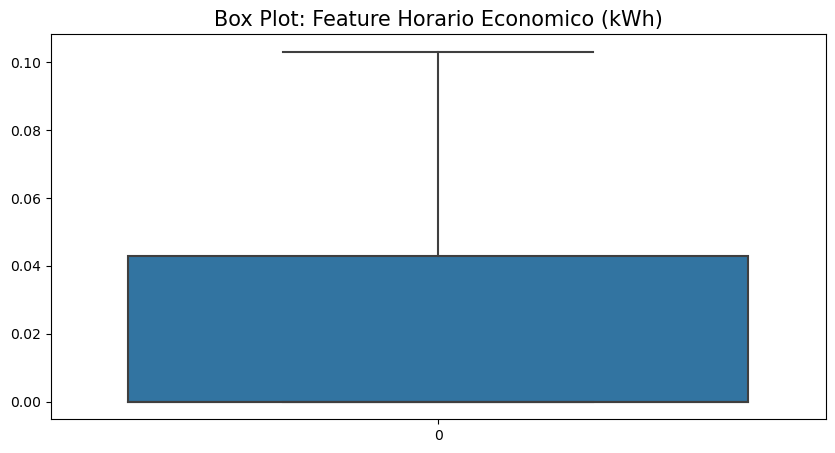

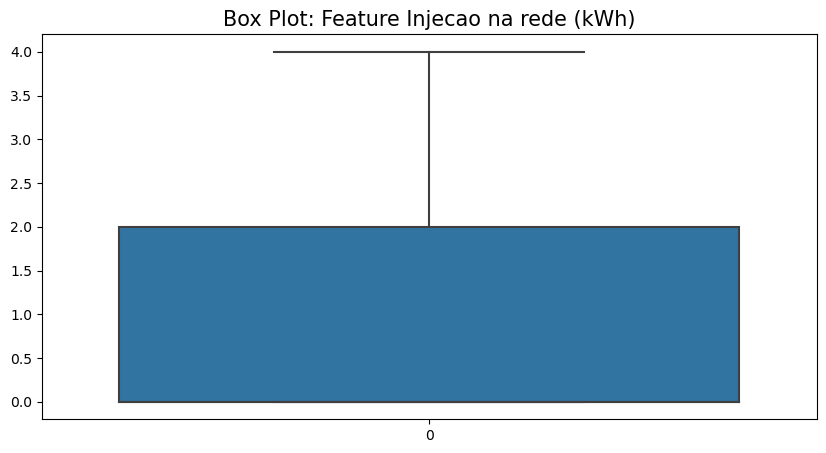

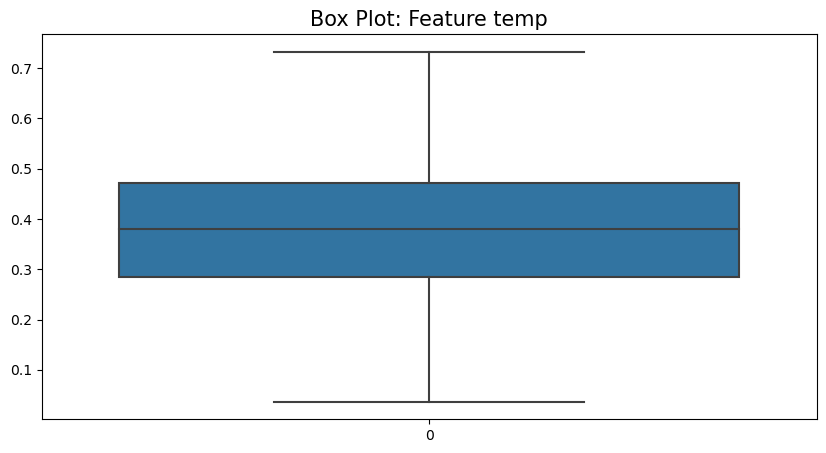

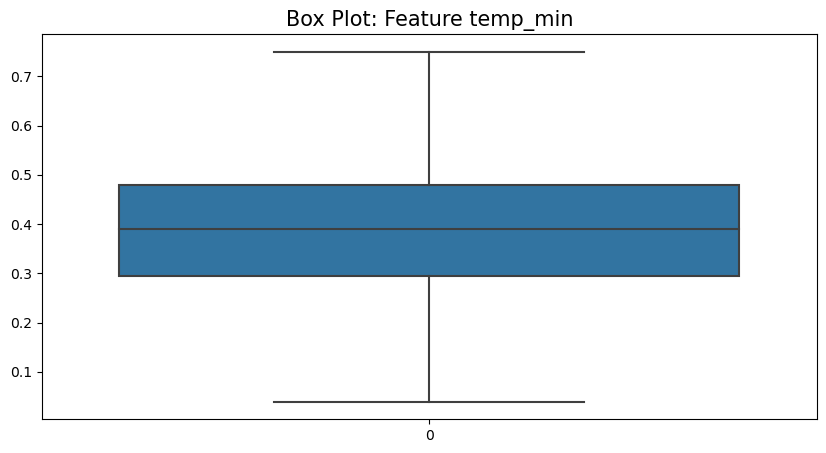

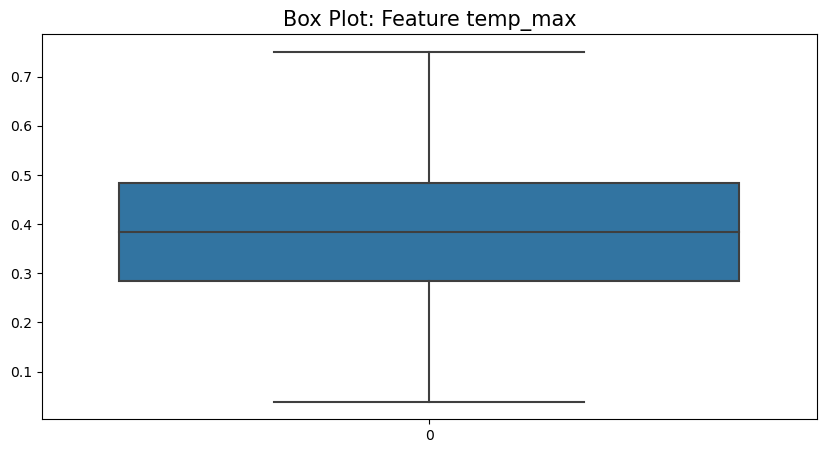

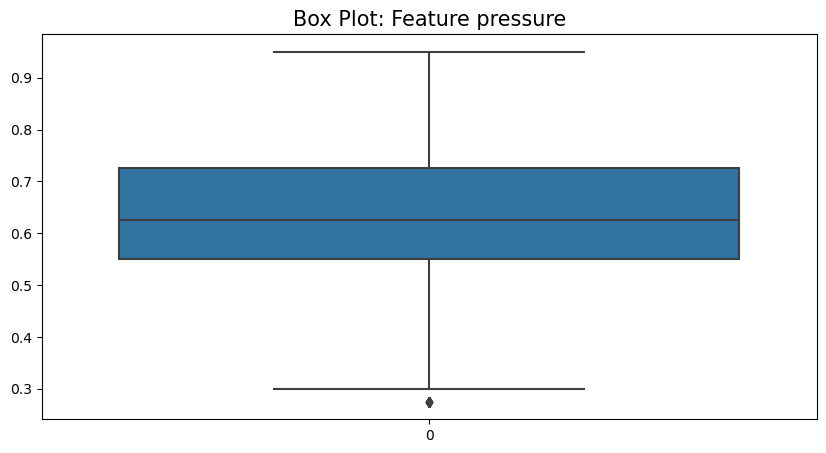

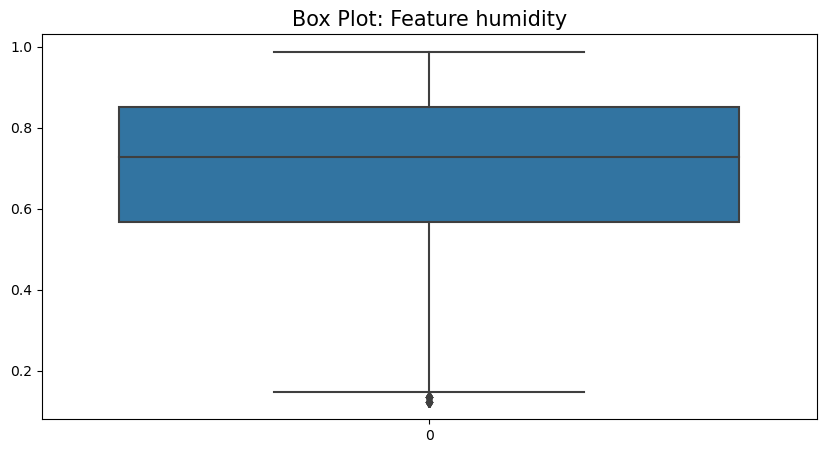

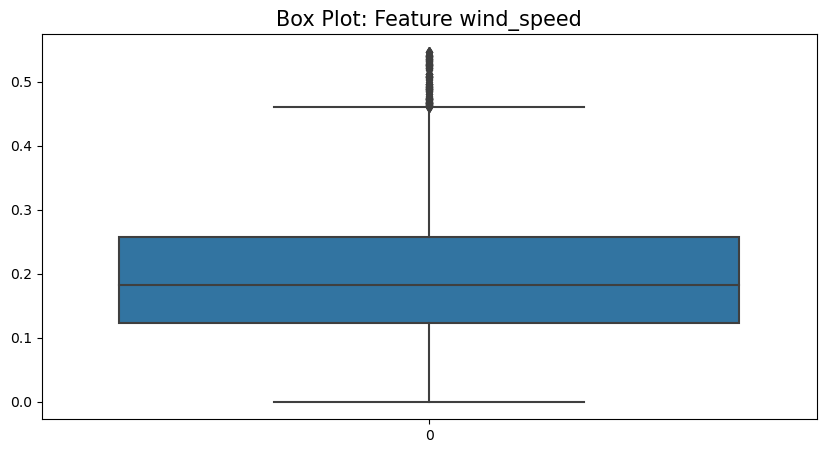

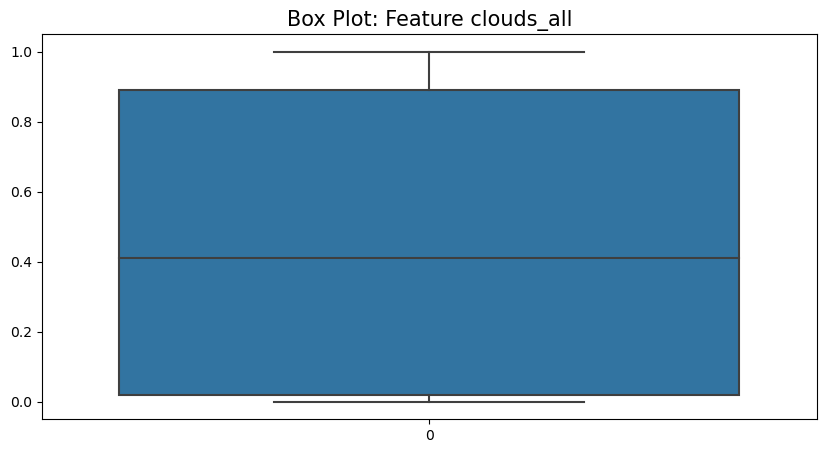

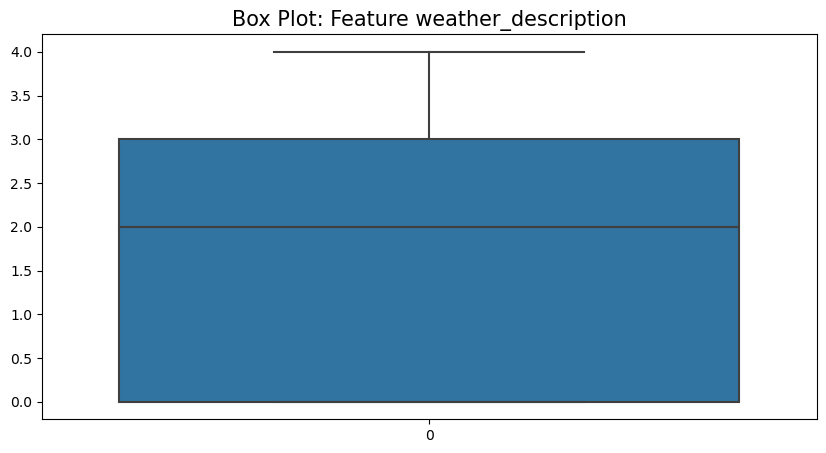

In [26]:
for num in numeric_columns:
    fig = plt.figure(figsize=(10,5))
    sns.boxplot(prep_df[num])
    plt.title('Box Plot: Feature ' + num, fontsize=15)
    plt.show()

- Quantidade de valores nulos em cada feature

In [27]:
sns.heatmap(prep_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<Axes: >

- Histograma de um conjunto univariante de observações da feature **incidents** (target)

In [28]:
train_df['Injecao na rede (kWh)'].unique()
train_df['Injecao na rede (kWh)'] = pd.Categorical(train_df['Injecao na rede (kWh)'], categories=['None', 'Low', 'Medium', 'High', 'Very High'])
sns.displot(train_df['Injecao na rede (kWh)'], kde=True)

ValueError: arange: cannot compute length

In [ ]:
sns.displot(prep_df['rain_1h '], kde=True)

KeyError: 'rain_1h '